In [1]:
import tensorflow as tf
import NERutils as utils

from DataLoading import LoadParquet
from DataTokensGenerator import DataTokens
from NamedEntityRecognitionLSTM import NamedEntityRecognition_LSTM

seed_value = 101
tf.random.set_seed(seed_value)

%matplotlib widget

In [2]:
train = LoadParquet('train.parquet')
dev = LoadParquet('dev.parquet')
test = LoadParquet('test.parquet')

In [3]:
train.head()

,tokens,pos_tags,chunk_tags,ner_tags
0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]"
2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]"
3,"[The, European, Commission, said, on, Thursday...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,"[Germany, 's, representative, to, the, Europea...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


In [4]:
Tokenizer = DataTokens(train_df = train, 
                       dev_df = dev, 
                       test_df = test, 
                       phrases_column = 'tokens', 
                       entities_column = 'ner_tags', 
                       num_words = 30000, 
                       words_in_list = True, 
                       custom_filter = '',
                       mini_batch_size = 256
                       )

Tokenizer.PreprocessTokens()   # Words are tokenized and padded
Tokenizer.PreprocessTags()     # NER tags are tokenized and padded

print("Shape of preprocessed training tokens:      ", Tokenizer.X_train.shape)
print("Shape of preprocessed development tokens:   ", Tokenizer.X_dev.shape)
print("Shape of preprocessed testing tokens:       ", Tokenizer.X_test.shape)
print()
print("Shape of preprocessed training NER tags:    ", Tokenizer.Y_train.shape)
print("Shape of preprocessed development NER tags: ", Tokenizer.Y_dev.shape)
print("Shape of preprocessed testing NER tags:     ", Tokenizer.Y_test.shape)
print()
print("Tokens representation: ", Tokenizer.X_train[0])
print("NER tags representation: ", Tokenizer.Y_train[0])

Shape of preprocessed training tokens:       (14041, 124)
Shape of preprocessed development tokens:    (3250, 124)
Shape of preprocessed testing tokens:        (3453, 124)

Shape of preprocessed training NER tags:     (14041, 124)
Shape of preprocessed development NER tags:  (3250, 124)
Shape of preprocessed testing NER tags:      (3453, 124)

Tokens representation:  [  989 10951   205   629     7  3939   216  5774     3     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0    

In [5]:
count = 0
target_value = 1
train_sequences = Tokenizer.X_train.tolist()
dev_sequences = Tokenizer.X_dev.tolist()
test_sequences = Tokenizer.X_test.tolist()

# Iterate through each list and count occurrences of the target value
for sublist in train_sequences:
    count += sublist.count(target_value)

print(f"The value <OOV> appears {count} times in the training sequences.")

count = 0
for sublist in dev_sequences:
    count += sublist.count(target_value)

print(f"The value <OOV> appears {count} times in the development sequences.")

count = 0
for sublist in test_sequences:
    count += sublist.count(target_value)

# Print the count
print(f"The value <OOV> appears {count} times in the test sequences.")

The value <OOV> appears 0 times in the training sequences.
The value <OOV> appears 3874 times in the development sequences.
The value <OOV> appears 5049 times in the test sequences.


In [6]:
# Find the maximum value in the 2D array
max_value = float('-inf')  # Initialize with negative infinity

for row in Tokenizer.Y_train.tolist():
    for element in row:
        if element > max_value:
            max_value = element

print("Number of named entities (including no entity):", max_value + 1)

Number of named entities (including no entity): 9


<h2 style='font-size: 23px; font-weight: bold; margin-bottom: 10px; font-family: 'Formata', serif;'>
        Modeling & Evaluation</h2>

In [7]:
loss_values = {}
sequence_length = Tokenizer.X_train.shape[1]

model = NamedEntityRecognition_LSTM()
    
model.vocabulary_size = 30000
model.embedding_dimension = 64
model.learning_rate = 0.0001
model.learning_rate_decay = False
Tokenizer.mini_batch_size = 256
model.many_to_many = True
model.lstm_hidden_nodes = [128, 128, 128]
model.dense_hidden_nodes = [128, 256, 128]
model.output_nodes = 9
model.bidirectional_lstm = True
model.batch_normalization = True
model.layer_normalization = True
model.optimizer = 'adam'
model.amsgrad_adam_mod = False
model.epochs = 40

model_name='Bidirectional-LSTM'
    
BidLSTM, history = model.CompileTrainModel(tokenizer = Tokenizer, 
                                           sequence_length = sequence_length, 
                                           model_name = model_name,
                                           final_model = True)
    
key = utils.get_key(history.history, 'loss')
loss = history.history[key]
loss_values[model_name + '-' + key] = loss

key = utils.get_key(history.history, 'val_loss')
loss = history.history[key]
loss_values[model_name + '-' + key] = loss


******************************************************
Model: "Bidirectional-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 124, 64)           1920064   
                                                                 
 Bidirectional-LSTM-Layer-1  (None, 124, 256)          197632    
  (Bidirectional)                                                
                                                                 
 layer_normalization (Layer  (None, 124, 256)          512       
 Normalization)                                                  
                                                                 
 Bidirectional-LSTM-Layer-2  (None, 124, 256)          394240    
  (Bidirectional)                                                
                                                                 
 layer_normalization_1 (Lay  (None, 124, 256)          512

2023-08-28 16:01:31.069631: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_42/output/_24'


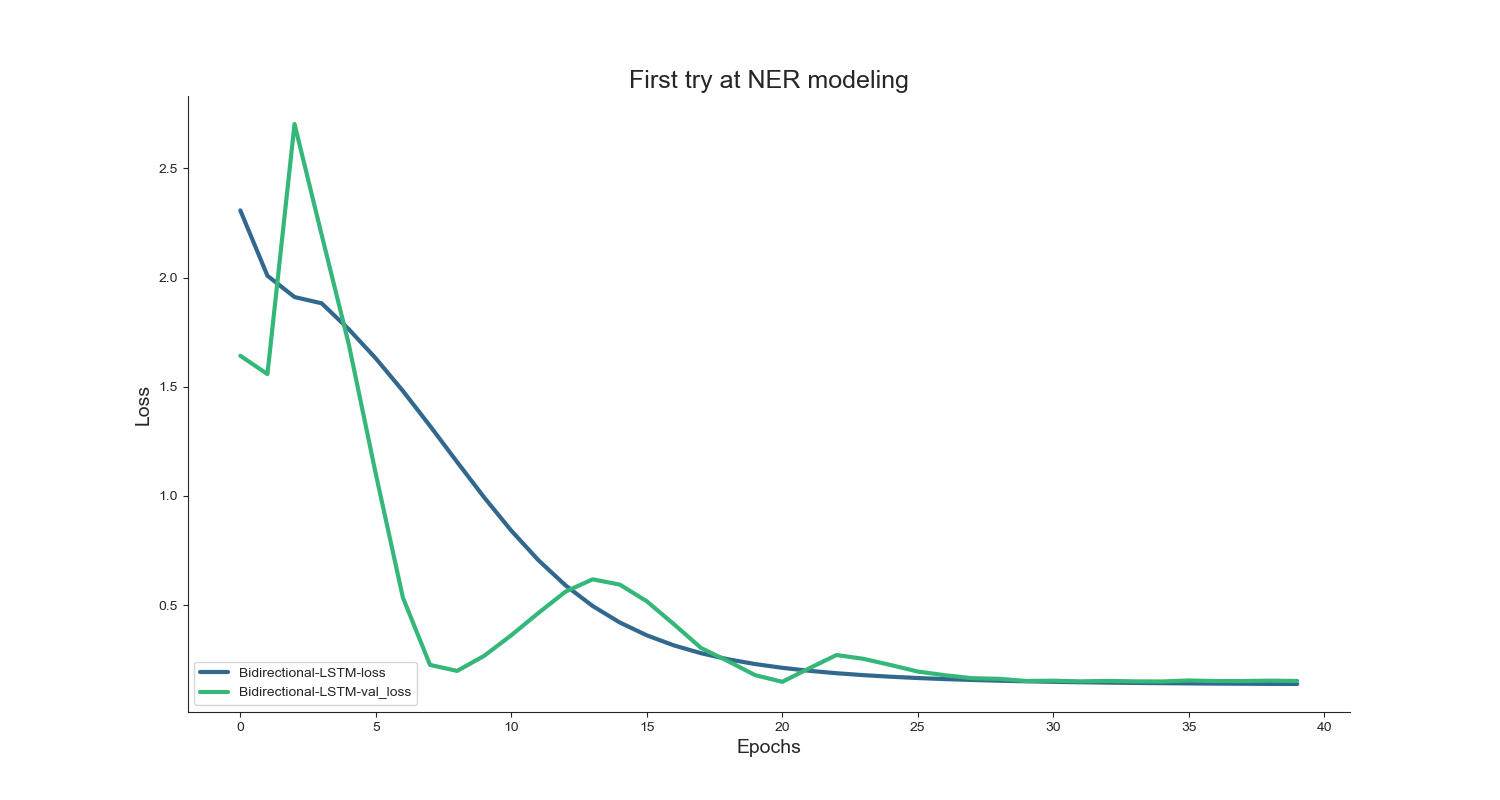

In [ ]:
utils.plot_loss(loss_values, 'First try at NER modeling')

In [ ]:
y_pred = BidLSTM.predict(Tokenizer.test)

14/14 [==============================] - 3s 114ms/step


In [ ]:
utils.evaluate_model(test['ner_tags'], y_pred)

Confusion Matrix:
 [[38323     0     0     0     0     0     0     0     0]
 [ 1617     0     0     0     0     0     0     0     0]
 [ 1156     0     0     0     0     0     0     0     0]
 [ 1661     0     0     0     0     0     0     0     0]
 [  835     0     0     0     0     0     0     0     0]
 [ 1668     0     0     0     0     0     0     0     0]
 [  257     0     0     0     0     0     0     0     0]
 [  702     0     0     0     0     0     0     0     0]
 [  216     0     0     0     0     0     0     0     0]]


Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.90     38323
           1       0.00      0.00      0.00      1617
           2       0.00      0.00      0.00      1156
           3       0.00      0.00      0.00      1661
           4       0.00      0.00      0.00       835
           5       0.00      0.00      0.00      1668
           6       0.00      0.00      0.00       257
        

/Users/luish/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luish/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luish/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
